In [1]:
from icevision.all import *
from fastai.callback.wandb import *

run = wandb.init(project="data-flywheel-training-eva-bowling-ball", name="Fix 1", reinit=True)

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
03/19/2024 05:19:16 - ERROR - wandb.jupyter -   Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dnth. Use `wandb login --relogin` to force relogin


In [2]:
artifact = wandb.Artifact("xmls", type="annotations")
artifact.add_dir("pascal_voc_annotations_bowling_ball/")
wandb.log_artifact(artifact)

wandb: Adding directory to artifact (./pascal_voc_annotations_bowling_ball)... Done. 0.8s


<Artifact xmls>

In [3]:
parser = parsers.VOCBBoxParser(annotations_dir='pascal_voc_annotations_bowling_ball/', 
                               images_dir='/workspace/yolo_v8_training/oiv7_full/train/')

In [4]:
# Parse annotations to create records
train_records, valid_records = parser.parse() # Defaults to 80:20 split
parser.class_map

  0%|          | 0/3758 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/3758 [00:00<?, ?it/s]

WARNING  - (record_id: 29a4f794debe1c43) - 🚫 Record could not be autofixed and will be removed because: File '/workspace/yolo_v8_training/oiv7_full/train/29a4f794debe1c43.xml' does not exist | icevision.core.record:autofix_records:100
WARNING  - (record_id: af446aede5e2193f) - 🚫 Record could not be autofixed and will be removed because: File '/workspace/yolo_v8_training/oiv7_full/train/af446aede5e2193f.xml' does not exist | icevision.core.record:autofix_records:100


<ClassMap: {'background': 0, 'bowling_ball': 1}>

In [5]:
image_size = 640
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=720), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [6]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [7]:
print(f"Train on {len(train_ds)} images")
print(f"Validate on {len(valid_ds)} images")

Train on 3004 images
Validate on 752 images


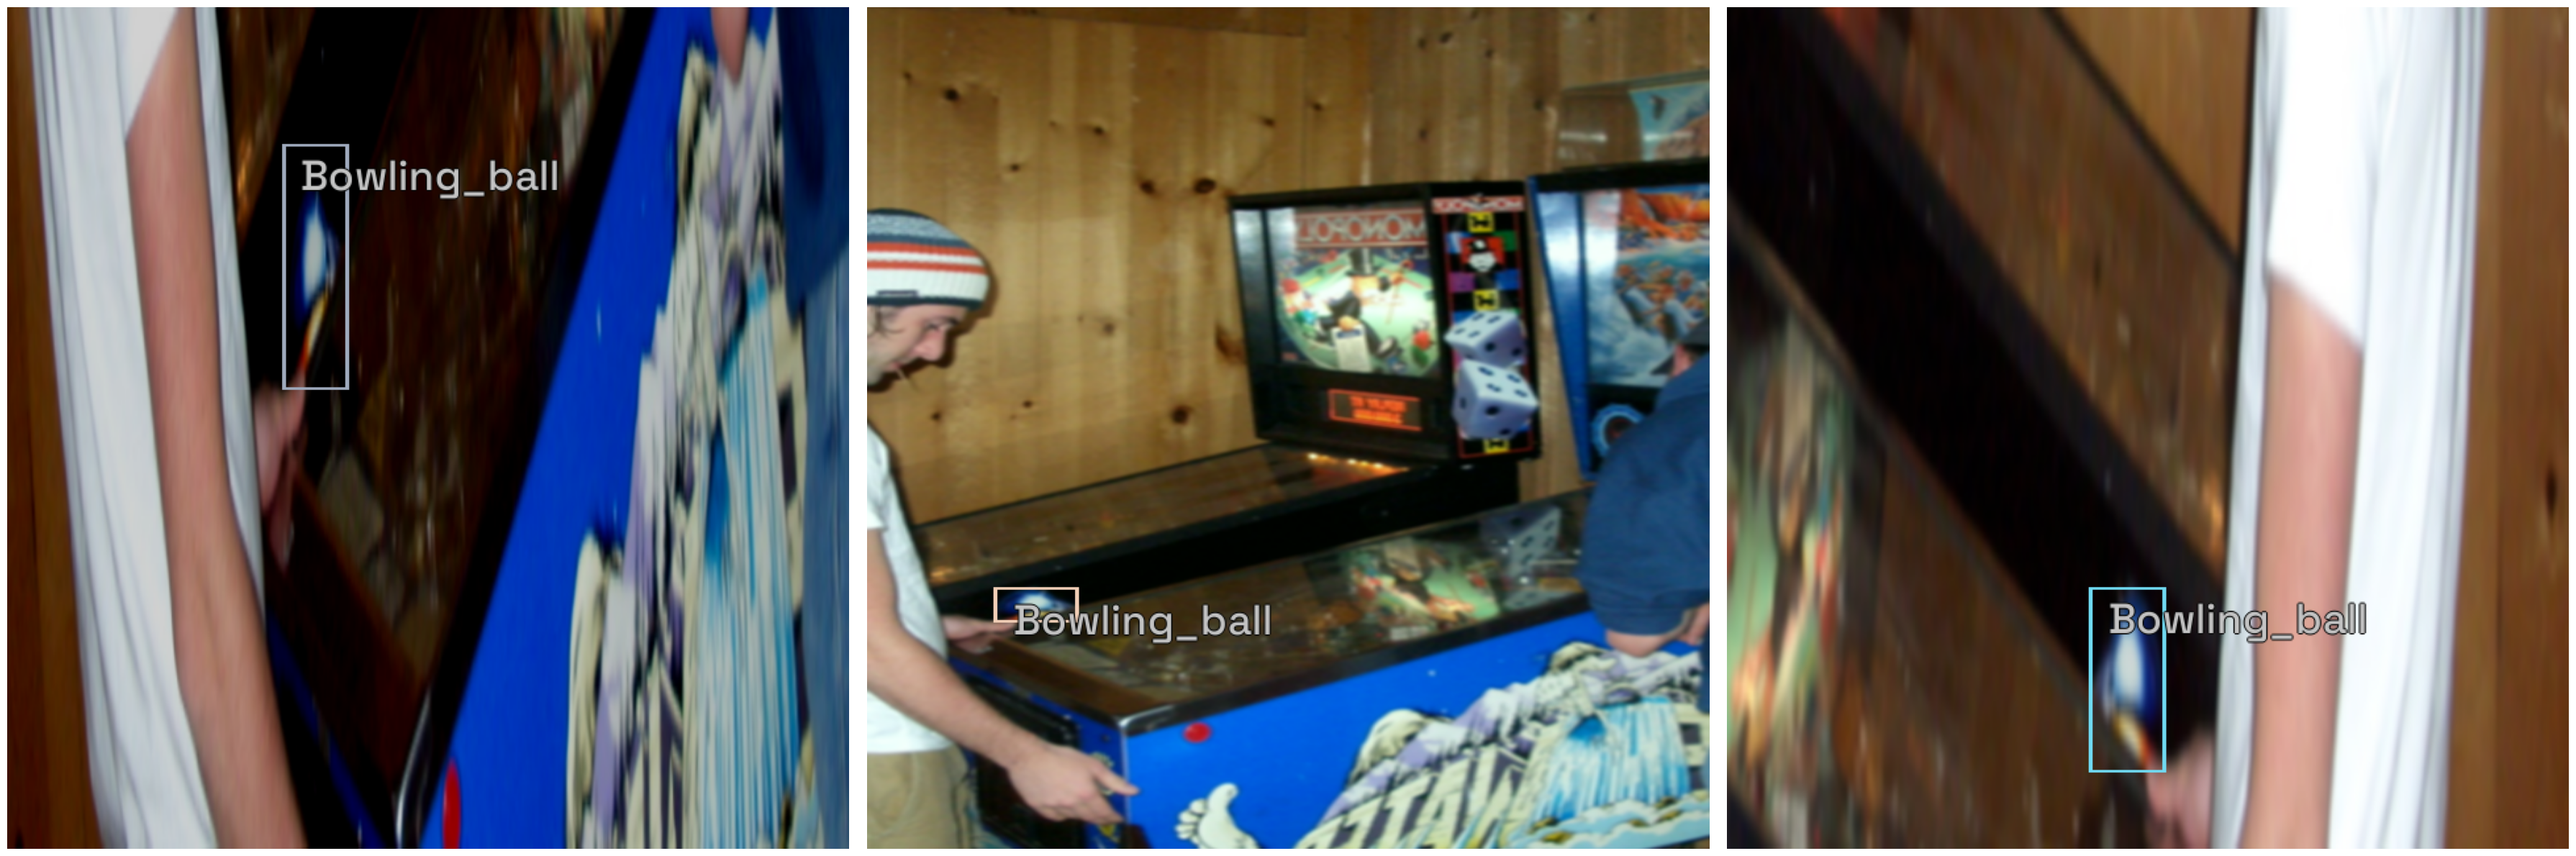

In [8]:
%matplotlib inline
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[1] for _ in range(3)]
show_samples(samples, ncols=3)

In [11]:
# model_type = models.mmdet.vfnet
# backbone = model_type.backbones.resnet50_fpn_mstrain_2x
# model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 


artifact = run.use_artifact('dnth/data-flywheel-training-eva-bowling-ball/vfnet-model:v0', type='trained-model-checkpoint')
artifact_dir = artifact.download()

# Load previously trained model
from icevision.models import *

# The model is automatically recreated in the evaluation mode. To unset that mode, you only need to pass `eval_mode=Fales`)
checkpoint_and_model = model_from_checkpoint('./artifacts/vfnet-model:v0/model_checkpoint.pth')

model = checkpoint_and_model["model"]
model_type = checkpoint_and_model["model_type"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]

wandb: Downloading large artifact vfnet-model:v0, 250.21MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.4


load checkpoint from local path: ./artifacts/vfnet-model:v0/model_checkpoint.pth


2024-03-19 05:21:36,916 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2024-03-19 05:21:36,917 - mmcv - INFO - load model from: torchvision://resnet50
2024-03-19 05:21:36,917 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
2024-03-19 05:21:36,969 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2024-03-19 05:21:36,984 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2024-03-19 05:21:37,003 - mmcv - INFO - initialize VFNetHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'vfnet_cls', 'std': 0.01, 'bias_prob': 0.01}}
2024-03-19 05:21:37,019 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2024-03-19 05:21:37,019 - mmcv - INFO -

In [12]:
train_dl = model_type.train_dl(train_ds, batch_size=32, num_workers=16, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=32, num_workers=16, shuffle=False)

In [13]:
from fastai.callback.tracker import SaveModelCallback

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], 
                                  model=model, 
                                  metrics=metrics,
                                  cbs=[WandbCallback(), SaveModelCallback(fname='best_model_weights')])

/root/miniforge-pypy3/envs/icevision/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SuggestedLRs(valley=2.0892961401841603e-05)

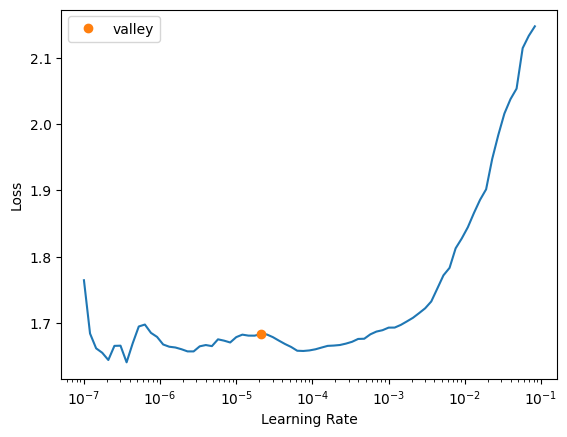

In [14]:
learn.lr_find()

In [15]:
learn.fine_tune(3, 3e-5, freeze_epochs=2)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


Better model found at epoch 0 with valid_loss value: 1.5332763195037842.
Could not gather input dimensions


Better model found at epoch 0 with valid_loss value: 1.5397965908050537.
Better model found at epoch 1 with valid_loss value: 1.5290671586990356.
Better model found at epoch 2 with valid_loss value: 1.5239176750183105.


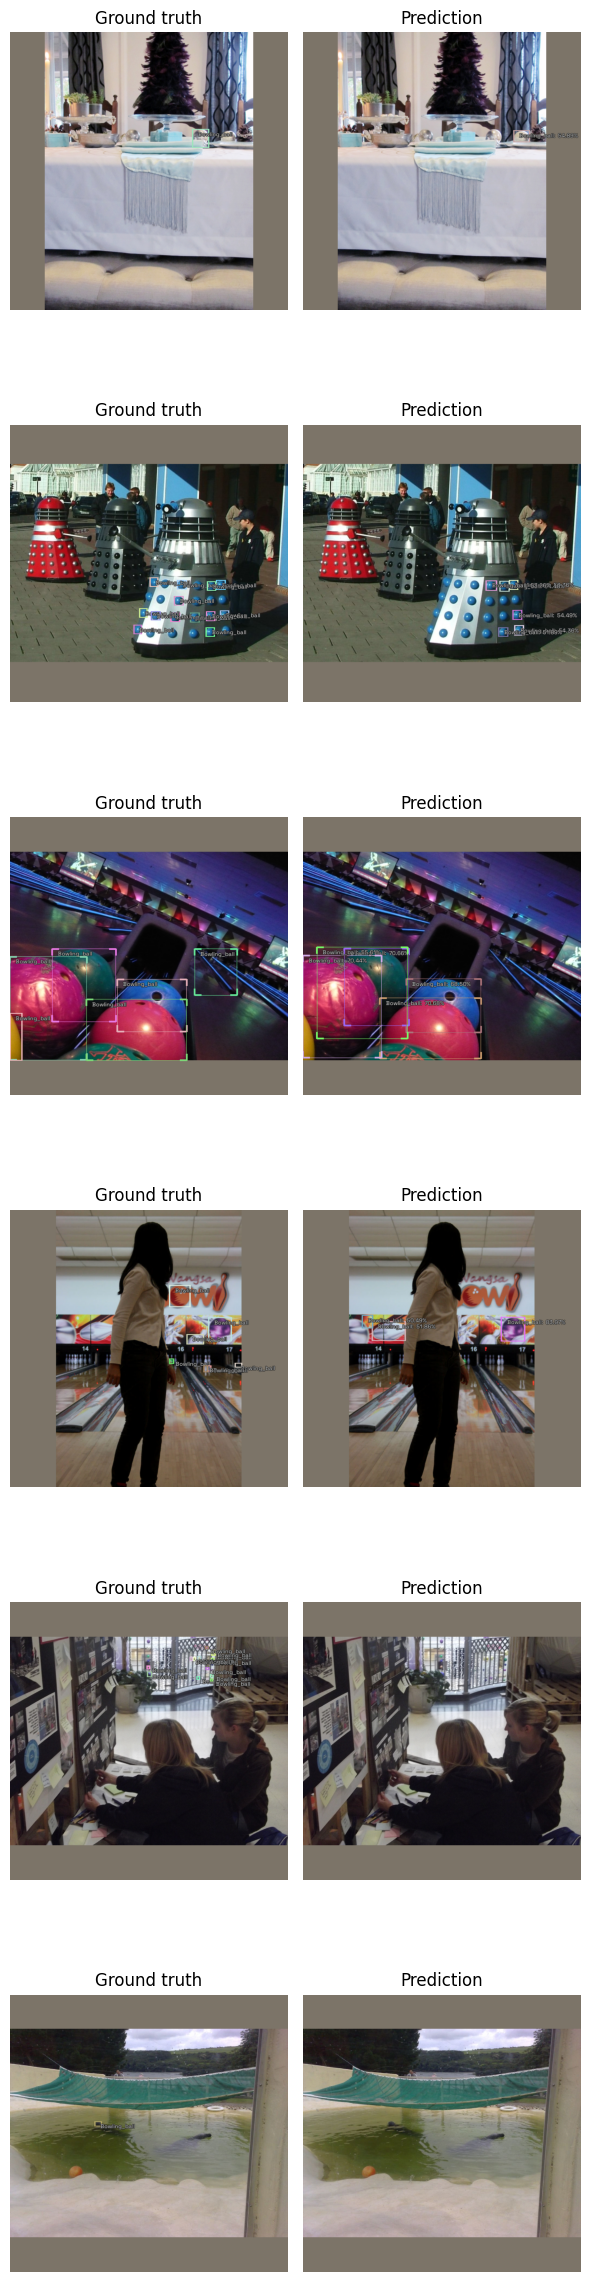

In [16]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

INFO     - Losses returned by model: ['loss_cls', 'loss_bbox'] | icevision.models.interpretation:plot_top_losses:219


  0%|          | 0/752 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

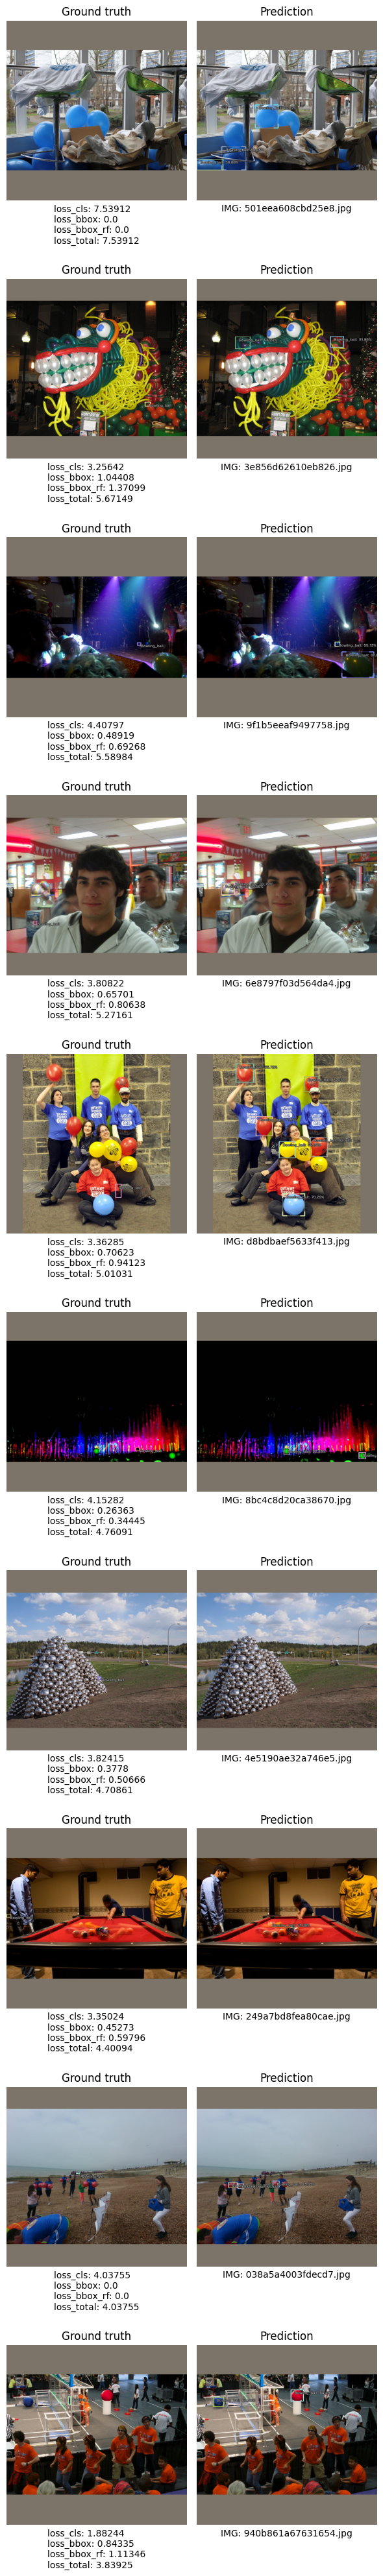

In [17]:
sorted_samples, sorted_preds, losses_stats = model_type.interp.plot_top_losses(model, valid_ds, sort_by="loss_total", n_samples=10)

In [ ]:
# infer_dl = model_type.infer_dl(valid_ds, batch_size=8)
# preds = model_type.predict_from_dl(model=model, infer_dl=infer_dl, keep_images=True)

# # Create wandb_images for each prediction
# wandb_images = wandb_img_preds(preds, add_ground_truth=True) 

# # Log the wandb_images to wandb
# wandb.log({"Predicted images from validation ds": wandb_images})

In [18]:
wandb_images = wandb_img_preds(sorted_preds, add_ground_truth=True) 
wandb.log({"Highest loss images": wandb_images})

In [19]:
from icevision.models.checkpoint import *
save_icevision_checkpoint(model,
                        model_name='mmdet.vfnet', 
                        backbone_name='resnet50_fpn_mstrain_2x',
                        img_size=640,
                        classes=parser.class_map.get_classes(),
                        filename='./models/model_checkpoint.pth',
                        meta={'icevision_version': 'master'})

In [20]:
artifact = wandb.Artifact("vfnet-model", type="trained-model-checkpoint")
artifact.add_dir("models/")
wandb.log_artifact(artifact)

wandb: Adding directory to artifact (./models)... Done. 0.2s


<Artifact vfnet-model>

In [21]:
to_relabel = [pred.record_id + '.xml' for pred in sorted_preds]

In [22]:
to_relabel

['501eea608cbd25e8.xml',
 '3e856d62610eb826.xml',
 '9f1b5eeaf9497758.xml',
 '6e8797f03d564da4.xml',
 'd8bdbaef5633f413.xml',
 '8bc4c8d20ca38670.xml',
 '4e5190ae32a746e5.xml',
 '249a7bd8fea80cae.xml',
 '038a5a4003fdecd7.xml',
 '940b861a67631654.xml',
 'f6c6821180898087.xml',
 'c95681fcd19d6ce5.xml',
 '9eb761e0d38fb5b1.xml',
 'dae6562bee4813be.xml',
 '6910ed48ac258e5f.xml',
 'd428f97ae10c51e7.xml',
 '190425ce5181e462.xml',
 '05c831990a7676db.xml',
 '716f8f2cad5e98b0.xml',
 '3b400f2b79be8201.xml',
 '3074e2f2909b51c8.xml',
 'cbd0c4409cc0ba88.xml',
 'c6020270057d4d8c.xml',
 '2214cc86407eadc4.xml',
 '1f8e3cb450f7b6a1.xml',
 '3d215fe4b581dd2c.xml',
 '0b61062c86da28fa.xml',
 '60a670e5c8a9aa4c.xml',
 'ac8329ec7f6ed71f.xml',
 '3fefef09e3196eba.xml',
 '7c3e5b2b54846535.xml',
 'cce674ffa8660153.xml',
 'fad62600371c668f.xml',
 '03b3e2a25882e5c7.xml',
 'e582ff13e453f20a.xml',
 '16c737fd38b213d6.xml',
 '572e9991835abc9e.xml',
 '365ea3fe90383230.xml',
 '269d20e793902b8c.xml',
 'c51f3d73522e51e2.xml',


In [23]:
with open('relabel_list.txt', 'w') as file:
    file.write('\n'.join(to_relabel))

In [24]:
artifact = wandb.Artifact("xml-files", type="relabel-list")
artifact.add_file("relabel_list.txt")
wandb.log_artifact(artifact)

<Artifact xml-files>

In [25]:
wandb.finish()